![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)
reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467

In [1]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import seaborn as sns

# FINAL REPORT
from sklearn.metrics import confusion_matrix # helper function to create confussion matrix
from sklearn.metrics import roc_curve, roc_auc_score # library for ploting ros curves
from sklearn.metrics import classification_report # does soem magic, looks cool though
from sklearn.metrics import mean_squared_error

In [2]:
# DOWNLOAD DATA
#df = yf.download(tickers = '^GSPC', start = '2000-1-1',end = '2018-12-31')
#df.to_csv('S&P500.csv')

# FEATURES

## TECHNICAL INDICATORS

In [3]:
# TODO: Remove, use the download up there
df = pd.read_csv("S&P500.csv",index_col='Date')
df.index = pd.to_datetime(df.index)

df['Average'] = df.ta.midprice(length=1) #midprice
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi(length=14)
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)
df["CCI"] = ta.cci(df.High, df.Low, df.Close, length=16)
df["AO"] = ta.ao(df.High, df.Low)
df["MOM"] = ta.mom(df.Close, length=16)
df["ATR"] = ta.atr(df.High, df.Low, df.Close, length=16)
df["BOP"] = ta.bop(df.Open, df.High, df.Low, df.Close, length=16)
df["RVI"] = ta.rvi(df.Close)
df["WPR"] = ta.willr(df.High, df.Low, df.Close, length=16)
df = pd.concat([df,ta.macd(df.Close, length = 16)],axis=1, join='inner')
df = pd.concat([df,ta.dm(df.High, df.Low, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stochrsi(df.Close, length=16)],axis=1, join='inner')
df = pd.concat([df,ta.stoch(df.High, df.Low, df.Close)],axis=1, join='inner')
print(df.columns.tolist())
df.tail()

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA160', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3']


,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,WPR,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,DMP_16,DMN_16,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,2416.620117,7657890000,2456.479980,57.340190,22.436434,2676.658997,...,-97.939363,-65.464728,-23.097394,-42.367334,6.956167,23.202391,0.000000,0.033494,5.051172,5.844141
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2380.720093,57.851429,19.206673,2667.797247,...,-100.000000,-77.496788,-28.103563,-49.393225,6.521406,25.342863,0.000000,0.016747,3.123275,4.893797
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2407.170044,61.809461,36.676548,2663.022498,...,-73.298079,-76.739049,-21.876659,-54.862390,9.702563,23.758934,14.878074,4.959358,11.840955,6.671801
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2443.520020,63.643879,39.240542,2659.212000,...,-67.622614,-73.585265,-14.978300,-58.606965,10.429909,22.274001,39.541051,18.139708,24.254052,13.072761
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3728440000,2496.579956,62.627395,38.991897,2654.289752,...,-61.553783,-70.522276,-9.532249,-60.990027,11.726160,20.881876,64.322874,39.580666,37.943085,24.679364


## DATES

In [4]:
def add_dates(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['Dayofweek'] = df.index.dayofweek
    #df['Quarter'] = df.index.quarter
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    #df['Dayofyear'] = df.index.dayofyear
    df['Dayofmonth'] = df.index.day
    #df['Weekofyear'] = df.index.isocalendar().week
    return df

df = add_dates(df)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,DMP_16,DMN_16,STOCHRSIk_16_14_3_3,STOCHRSId_16_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3,Dayofweek,Month,Year,Dayofmonth
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,2416.620117,7657890000,2456.479980,57.340190,22.436434,2676.658997,...,6.956167,23.202391,0.000000,0.033494,5.051172,5.844141,4,12,2018,21
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2380.720093,57.851429,19.206673,2667.797247,...,6.521406,25.342863,0.000000,0.016747,3.123275,4.893797,0,12,2018,24
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2407.170044,61.809461,36.676548,2663.022498,...,9.702563,23.758934,14.878074,4.959358,11.840955,6.671801,2,12,2018,26
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2443.520020,63.643879,39.240542,2659.212000,...,10.429909,22.274001,39.541051,18.139708,24.254052,13.072761,3,12,2018,27
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3728440000,2496.579956,62.627395,38.991897,2654.289752,...,11.726160,20.881876,64.322874,39.580666,37.943085,24.679364,4,12,2018,28


## ADD LAGS

In [5]:
def add_lags(df):
    target_map = df['Volume'].to_dict()
    df['Year_Ago'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['Half_Year_Ago'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['Month_Ago'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    return df
df = add_lags(df)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,STOCHRSId_16_14_3_3,STOCHk_14_3_3,STOCHd_14_3_3,Dayofweek,Month,Year,Dayofmonth,Year_Ago,Half_Year_Ago,Month_Ago
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,2416.620117,7657890000,2456.479980,57.340190,22.436434,2676.658997,...,0.033494,5.051172,5.844141,4,12,2018,21,3.293130e+09,5.468110e+09,3.237400e+09
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2380.720093,57.851429,19.206673,2667.797247,...,0.016747,3.123275,4.893797,0,12,2018,24,NaN,3.663280e+09,NaN
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2407.170044,61.809461,36.676548,2663.022498,...,4.959358,11.840955,6.671801,2,12,2018,26,1.970660e+09,3.803990e+09,3.523520e+09
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2443.520020,63.643879,39.240542,2659.212000,...,18.139708,24.254052,13.072761,3,12,2018,27,2.202900e+09,3.461100e+09,3.494380e+09
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3728440000,2496.579956,62.627395,38.991897,2654.289752,...,39.580666,37.943085,24.679364,4,12,2018,28,2.174890e+09,3.586800e+09,3.984540e+09


## TARGETS

In [6]:
# ADD TARGET FOR VOLUME
df['TargetNextClose'] = df['Volume'].shift(-1)
df['Target'] = df['Volume']-df['Volume'].shift(-1)
df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))] #TODO: pridat komplexnejsi categorizaci
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,Dayofweek,Month,Year,Dayofmonth,Year_Ago,Half_Year_Ago,Month_Ago,TargetNextClose,Target,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,2416.620117,7657890000,2456.479980,57.340190,22.436434,2676.658997,...,4,12,2018,21,3.293130e+09,5.468110e+09,3.237400e+09,2.613670e+09,5.044220e+09,1
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2380.720093,57.851429,19.206673,2667.797247,...,0,12,2018,24,NaN,3.663280e+09,NaN,4.249740e+09,-1.636070e+09,0
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2407.170044,61.809461,36.676548,2663.022498,...,2,12,2018,26,1.970660e+09,3.803990e+09,3.523520e+09,4.139010e+09,1.107300e+08,1
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2443.520020,63.643879,39.240542,2659.212000,...,3,12,2018,27,2.202900e+09,3.461100e+09,3.494380e+09,3.728440e+09,4.105700e+08,1
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3728440000,2496.579956,62.627395,38.991897,2654.289752,...,4,12,2018,28,2.174890e+09,3.586800e+09,3.984540e+09,NaN,NaN,0


# ANALÝZA DAT

## OUTLIERS

<AxesSubplot:ylabel='Frequency'>

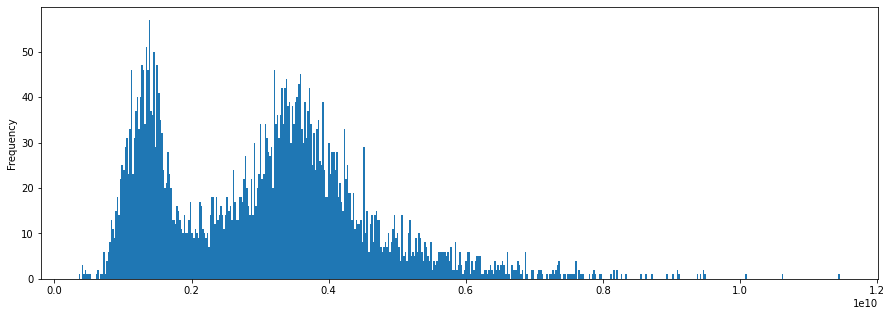

In [7]:
# OUTLIERS
df['Volume'].plot(kind='hist', bins=500,figsize=(15, 5))

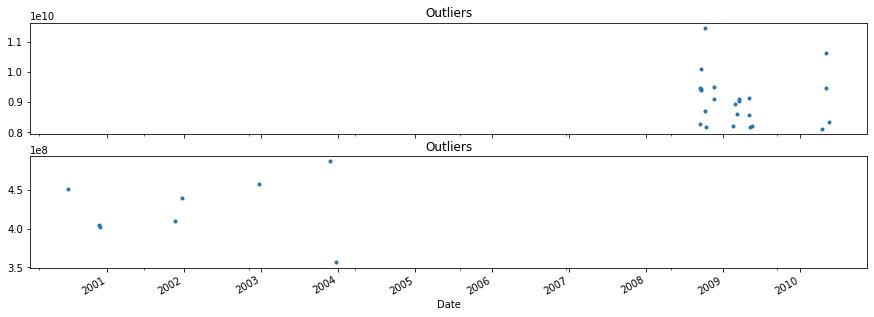

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15, 15), sharex=True)

# UPPER OUTLIERS
df.query('Volume > 0.8*1e10')['Volume'].plot(ax=axs[0],style='.',
          figsize=(15, 5),
          title='Outliers')
df = df.query('Volume < 0.8*1e10').copy() #Remove

# LOWER OUTLIERS
df.query('Volume < 0.05*1e10')['Volume'].plot(ax=axs[1],style='.',
          figsize=(15, 5),
          title='Outliers')
df = df.query('Volume > 0.05*1e10').copy() # REMOVE OUTLIERS

<AxesSubplot:ylabel='Frequency'>

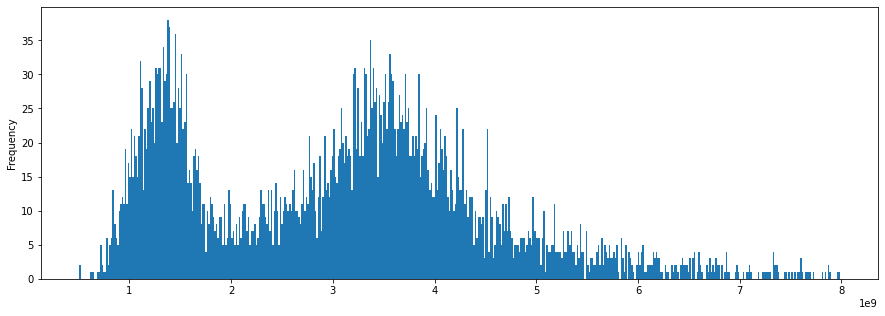

In [9]:
# CHECK RESULTS
df['Volume'].plot(kind='hist', bins=500,figsize=(15, 5))

## NA VALUES

In [11]:
# DROP THE NA VALUES
#df.isna().sum()
#df.dropna(inplace=True)
#data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)
#df.reset_index(drop=True, inplace=True)
#df.reset_index('Date')
#df.tail()

## DISTRIBUCE

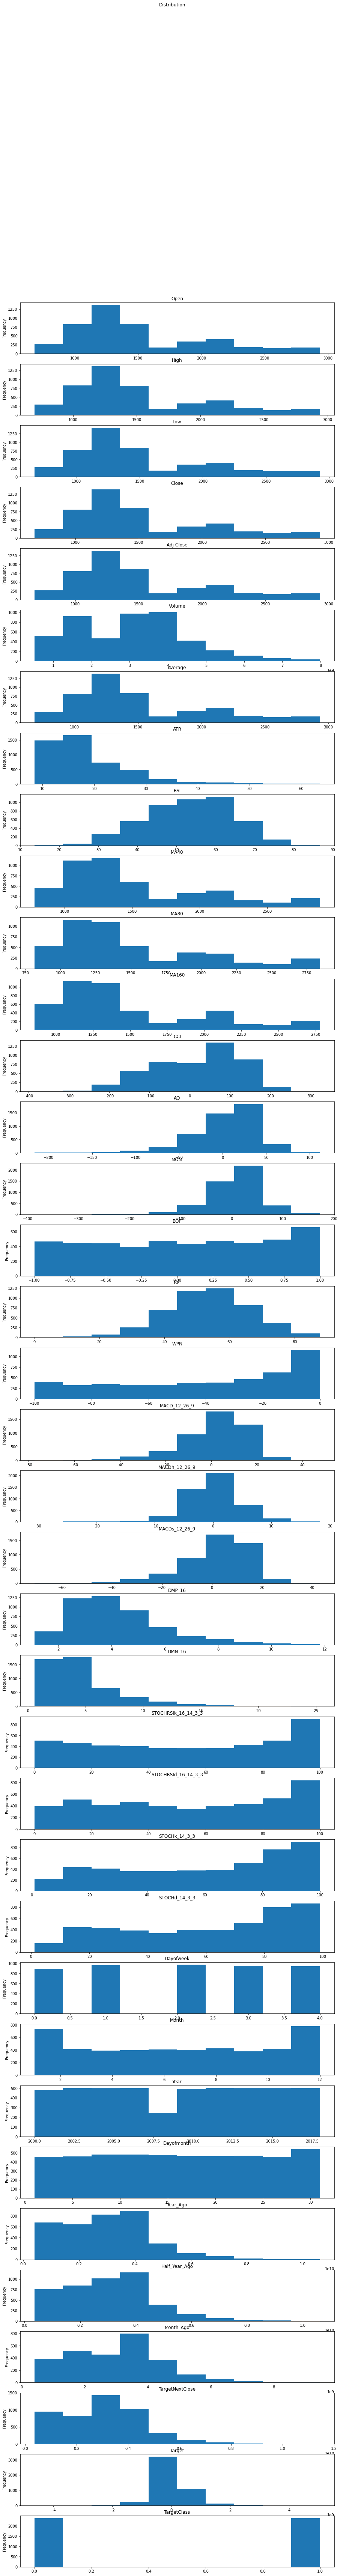

In [12]:
cols = df.columns.tolist()
fig, axs = plt.subplots(len(cols), 1,figsize=(15, len(cols)*3)) #TODO: zobrazit vsechno rozdeleni se spolecnou x osou, at zjistime, zda neco neni skew
plt.suptitle('Distribution')
for i in range(len(cols)):
    df[cols[i]].plot(kind='hist',ax=axs[i],title=cols[i])
plt.savefig('Distribution.pdf')

## KORELACE

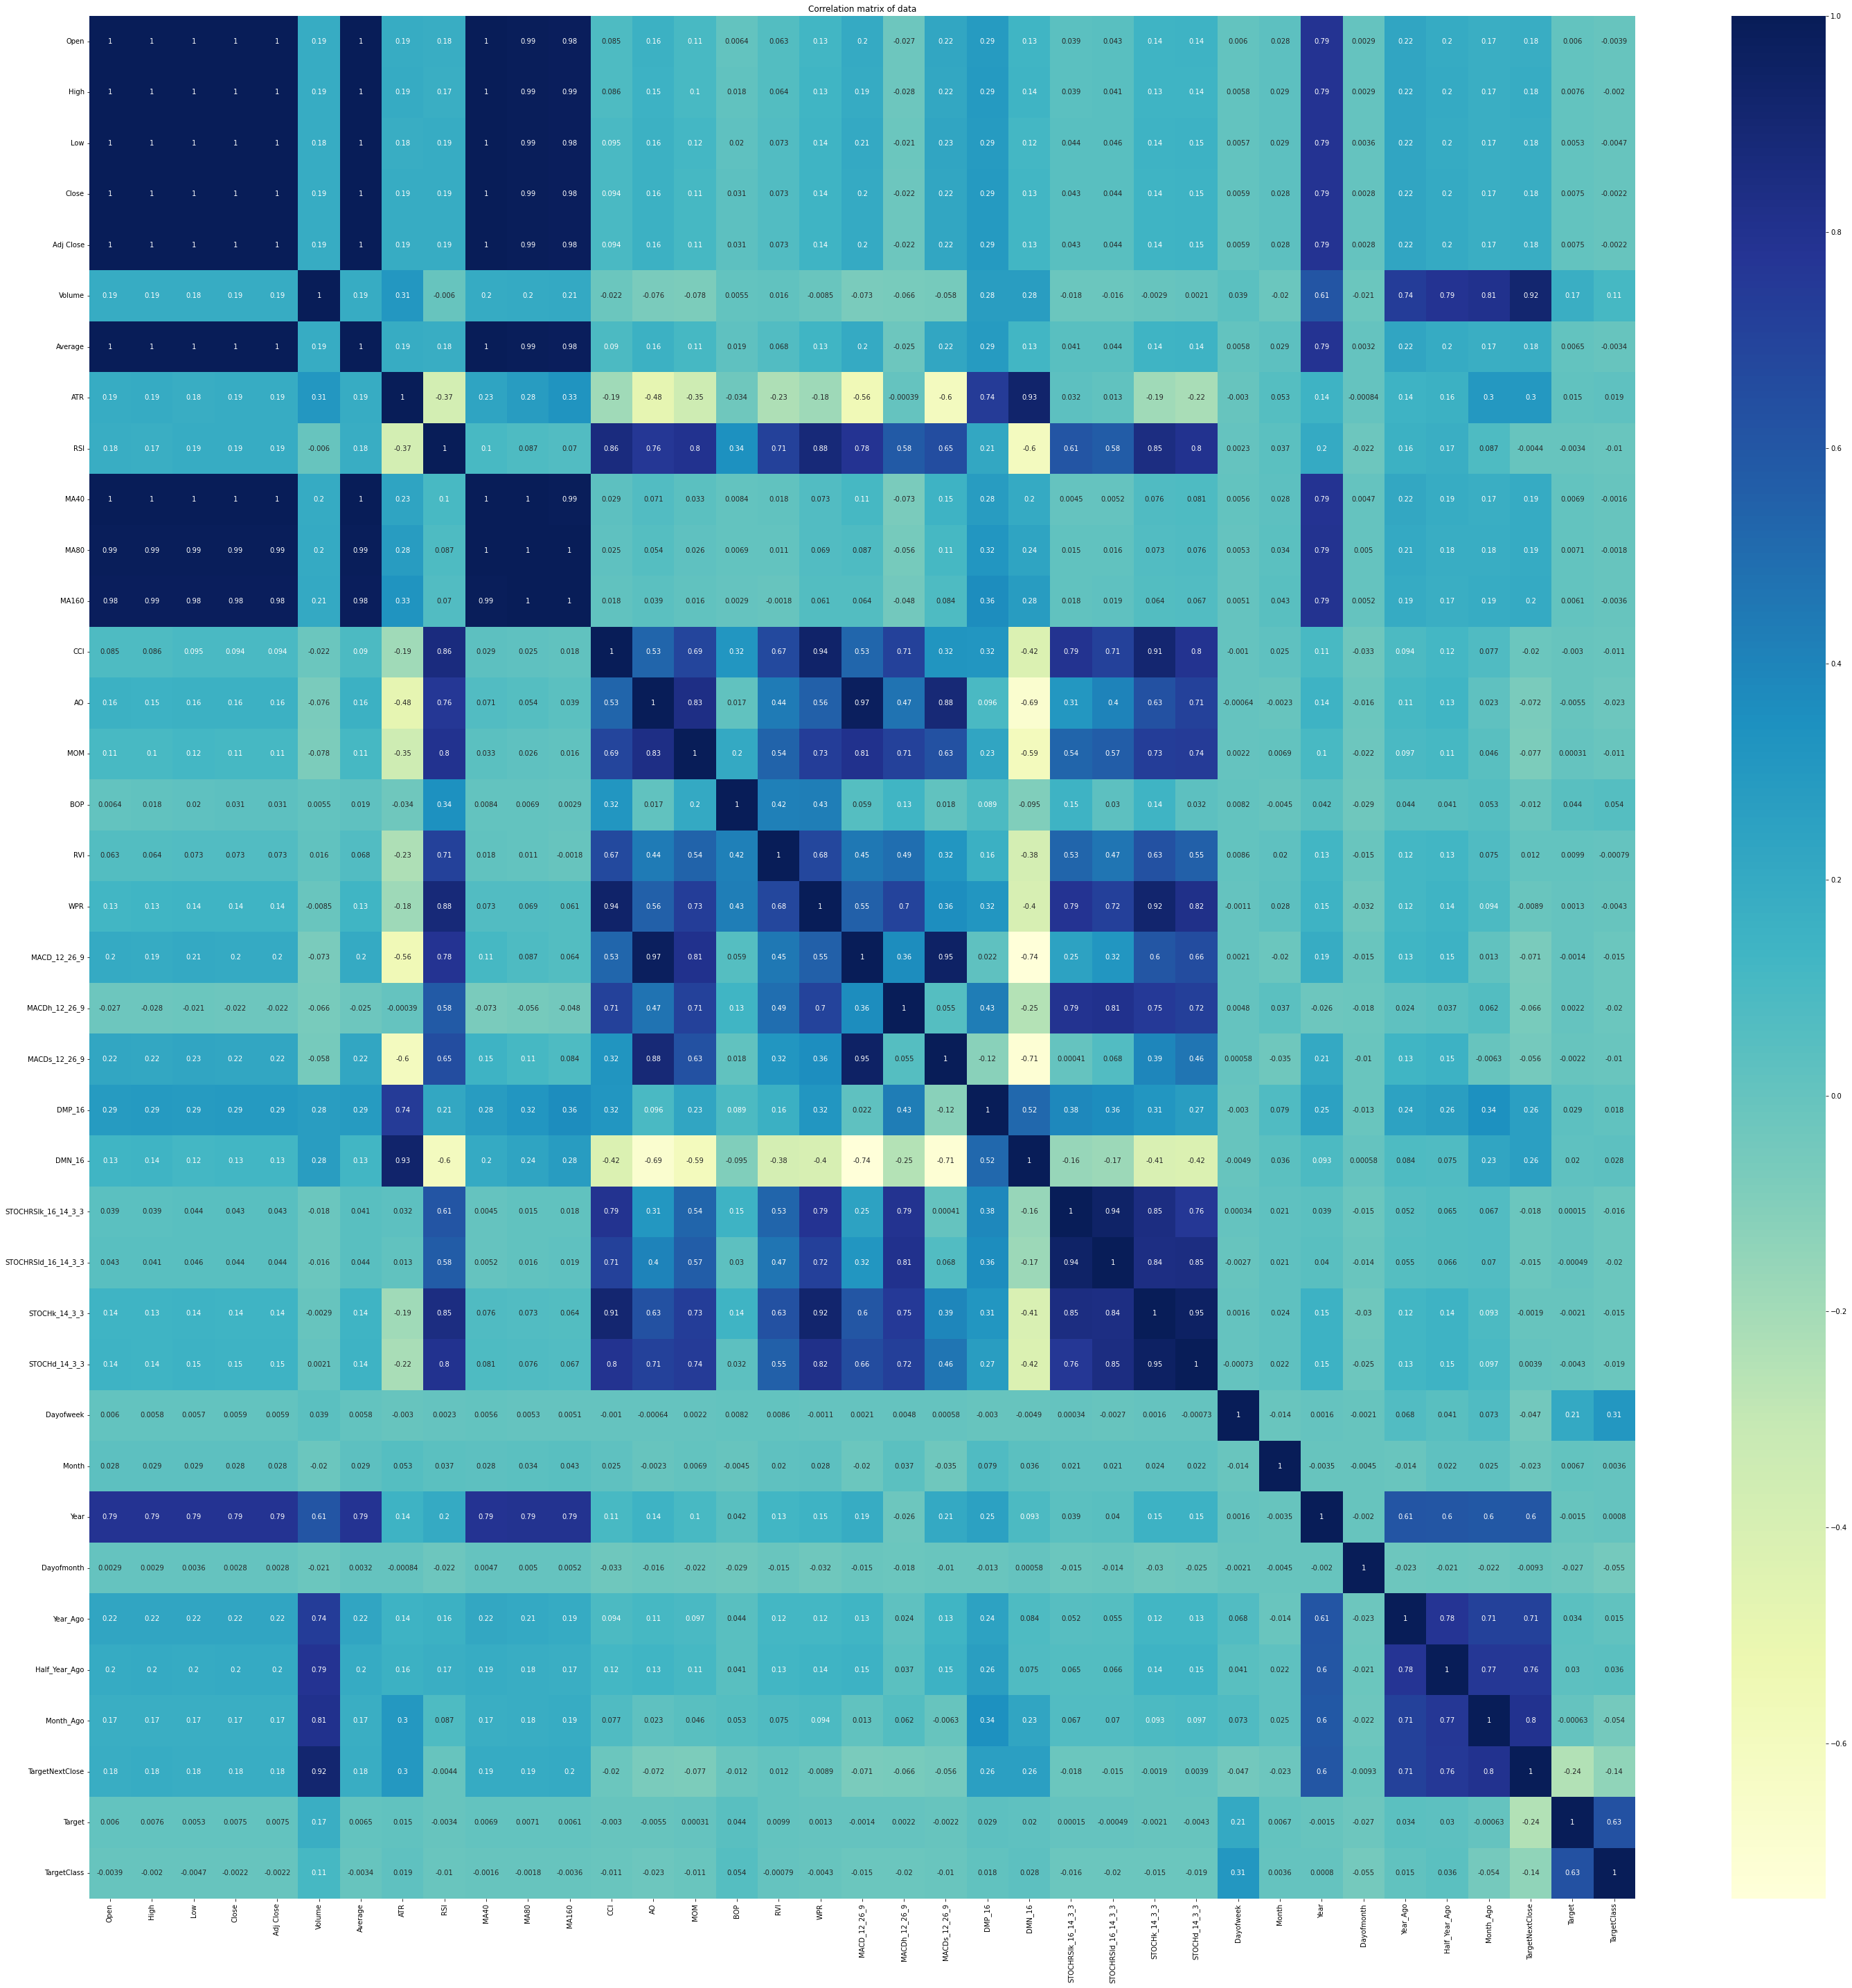

In [13]:
plt.figure(figsize=(50, 50))
plt.title('Correlation matrix of data')
cor = df.corr()
hm1 = sns.heatmap(cor, annot=True, cmap='YlGnBu')
plt.savefig('Correlation.pdf')

## OCCURING PATTERNS?
* check if there are some ireularities during days/weeks/months with higher trading volume

<AxesSubplot:xlabel='Dayofmonth'>

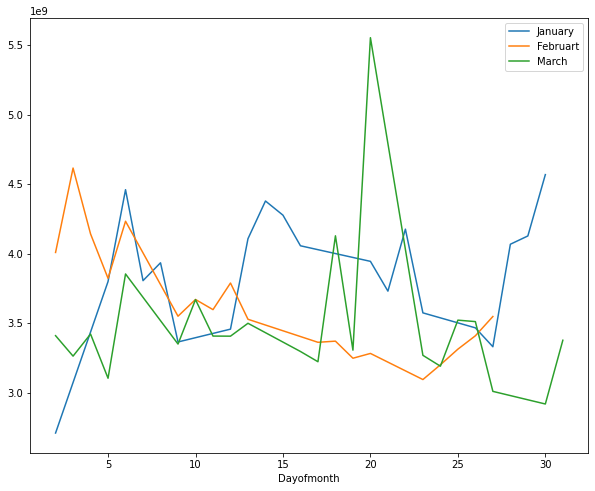

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
df.loc[(df.index > '01-01-2015') & (df.index < '02-01-2015')].plot(ax=ax,x='Dayofmonth',y='Volume', label='January')
df.loc[(df.index > '02-01-2015') & (df.index < '03-01-2015')].plot(ax=ax,x='Dayofmonth',y='Volume', label='Februart')
df.loc[(df.index > '03-01-2015') & (df.index < '04-01-2015')].plot(ax=ax,x='Dayofmonth',y='Volume', label='March')

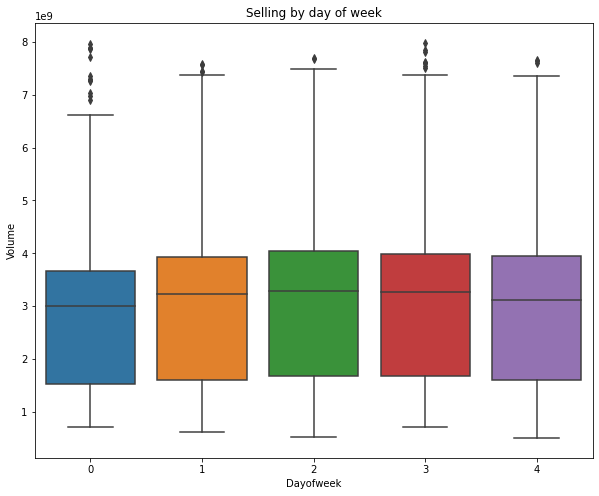

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Dayofweek', y='Volume')
ax.set_title('Selling by day of week')
plt.show()

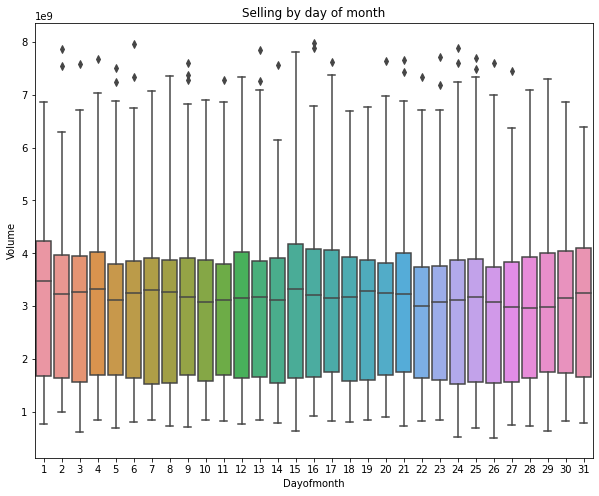

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Dayofmonth', y='Volume')
ax.set_title('Selling by day of month')
plt.show()

In [17]:
df_orig = df.copy()

## NORMALIZE

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scaled = sc.fit_transform(df)
df=pd.DataFrame(scaled,columns=df.columns,index=df.index)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,Dayofweek,Month,Year,Dayofmonth,Year_Ago,Half_Year_Ago,Month_Ago,TargetNextClose,Target,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,0.791055,0.805623,0.770581,0.771926,0.771926,0.956335,0.787865,0.885862,0.120430,0.898821,...,1.00,1.0,1.0,0.666667,0.282998,0.498165,0.313025,0.203384,0.956335,1.0
2018-12-24,0.762323,0.763733,0.745164,0.742860,0.742860,0.281967,0.754210,0.895119,0.076215,0.894632,...,0.00,1.0,1.0,0.766667,NaN,0.322285,NaN,0.350776,0.281967,1.0
2018-12-26,0.745727,0.789303,0.743165,0.794585,0.794585,0.500695,0.765960,0.966785,0.315374,0.892375,...,0.50,1.0,1.0,0.833333,0.153544,0.335998,0.344614,0.340800,0.500695,1.0
2018-12-27,0.780913,0.798806,0.765887,0.803959,0.803959,0.485892,0.782108,1.000000,0.350474,0.890574,...,0.75,1.0,1.0,0.866667,0.176278,0.302583,0.341397,0.303813,0.485891,1.0
2018-12-28,0.805856,0.812686,0.799046,0.802588,0.802588,0.431002,0.805679,0.981595,0.347070,0.888247,...,1.00,1.0,1.0,0.900000,0.173536,0.314833,0.395512,NaN,NaN,0.0


## NORMALIZOVANA DISTRIBUCE

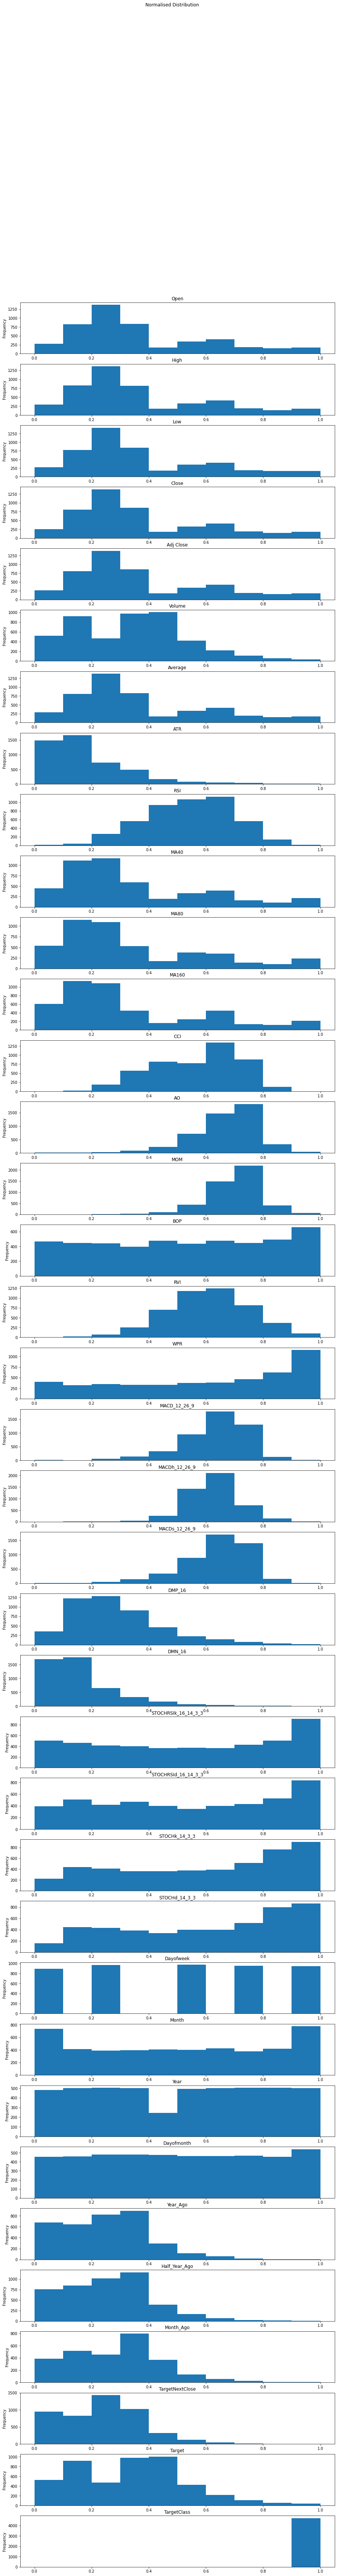

In [ ]:
cols = df.columns.tolist()
fig, axs = plt.subplots(len(cols), 1,figsize=(15, len(cols)*3)) #TODO: zobrazit vsechno rozdeleni se spolecnou x osou, at zjistime, zda neco neni skew
plt.suptitle('Normalised Distribution')
for i in range(len(cols)):
    df[cols[i]].plot(kind='hist',ax=axs[i],title=cols[i])
plt.savefig('Distribution Normalised.pdf')

# XGBOOST

## TEST 1

### TRAIN/TEST SPLIT - VOLUME

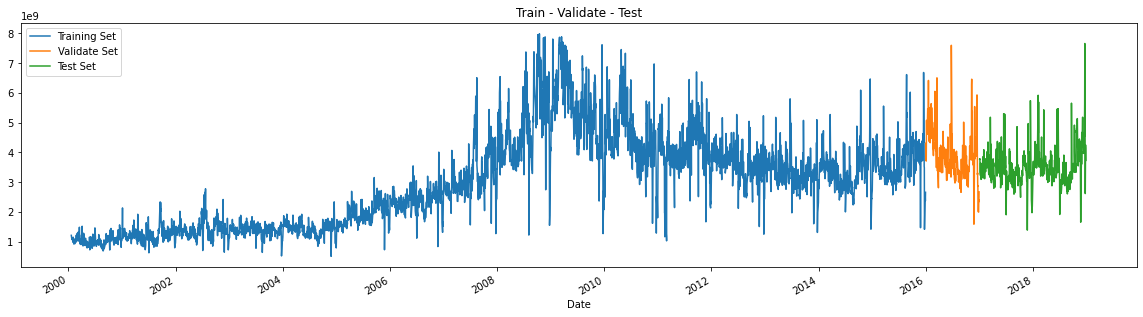

In [18]:
train = df.loc[df.index < '01-01-2017'].copy()
test = df.loc[df.index >= '01-01-2017'].copy()
validate = train.loc[train.index > '01-01-2016']
train = df.loc[df.index < '01-01-2016']

fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Volume',label='Training Set',title='Train - Validate - Test')
validate.plot(ax=ax, y='Volume', label='Validate Set')
test.plot(ax=ax, y='Volume', label='Test Set')
plt.show()

### TRAIN/TEST SPLIT - PRICE

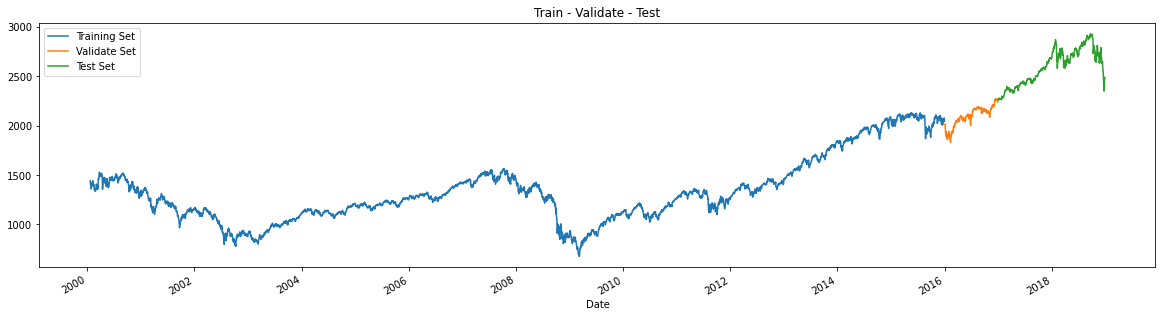

In [19]:
fig, ax = plt.subplots(figsize=(20, 5))
train.plot(ax=ax, y='Close',label='Training Set',title='Train - Validate - Test')
validate.plot(ax=ax, y='Close', label='Validate Set')
test.plot(ax=ax, y='Close', label='Test Set')
plt.show()

In [20]:
print(df.columns.tolist())
df.tail()

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Average', 'ATR', 'RSI', 'MA40', 'MA80', 'MA160', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Year', 'Dayofmonth', 'Year_Ago', 'Half_Year_Ago', 'Month_Ago', 'TargetNextClose', 'Target', 'TargetClass']


,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,Dayofweek,Month,Year,Dayofmonth,Year_Ago,Half_Year_Ago,Month_Ago,TargetNextClose,Target,TargetClass
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,2465.379883,2504.409912,2408.550049,2416.620117,2416.620117,7657890000,2456.479980,57.340190,22.436434,2676.658997,...,4,12,2018,21,3.293130e+09,5.468110e+09,3.237400e+09,2.613670e+09,5.044220e+09,1
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2380.720093,57.851429,19.206673,2667.797247,...,0,12,2018,24,NaN,3.663280e+09,NaN,4.249740e+09,-1.636070e+09,0
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2407.170044,61.809461,36.676548,2663.022498,...,2,12,2018,26,1.970660e+09,3.803990e+09,3.523520e+09,4.139010e+09,1.107300e+08,1
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2443.520020,63.643879,39.240542,2659.212000,...,3,12,2018,27,2.202900e+09,3.461100e+09,3.494380e+09,3.728440e+09,4.105700e+08,1
2018-12-28,2498.770020,2520.270020,2472.889893,2485.739990,2485.739990,3728440000,2496.579956,62.627395,38.991897,2654.289752,...,4,12,2018,28,2.174890e+09,3.586800e+09,3.984540e+09,NaN,NaN,0


In [21]:
# DO NOT USE Open-High-Low-Close-Adj Close
# Why? We know the market! Which we do not in real life
FEATURES = ['ATR', 'RSI', 'MA40', 'MA80', 'MA160', 'CCI', 'AO', 'MOM', 'BOP', 'RVI', 'WPR', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'DMP_16', 'DMN_16', 'STOCHRSIk_16_14_3_3', 'STOCHRSId_16_14_3_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3', 'Dayofweek', 'Month', 'Dayofmonth',  'Year_Ago', 'Half_Year_Ago', 'Month_Ago','TargetClass']
TARGET = 'Volume'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:linear',
                       max_depth=5,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:11:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:3272976424.09572	validation_1-rmse:3546428745.82305
[100]	validation_0-rmse:1317237897.82758	validation_1-rmse:1355949870.55903
[200]	validation_0-rmse:659114132.82760	validation_1-rmse:676995775.22372
[300]	validation_0-rmse:466926166.52358	validation_1-rmse:546775631.30536
[400]	validation_0-rmse:405177268.72483	validation_1-rmse:539769554.19000
[500]	validation_0-rmse:373243473.88389	validation_1-rmse:549201980.05551
[600]	validation_0-rmse:352566879.43560	validation_1-rmse:558757680.47651
[700]	validation_0-rmse:338449687.58697	validation_1-rmse:670669567.93579
[800]	validation_0-rmse:325748403.41883	validation_1-rmse:747276775.25881
[859]	validation_0-rmse:319550290.10461	validation_1-rmse:788129577.16164


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=500, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto', ...)

### Feature Importance

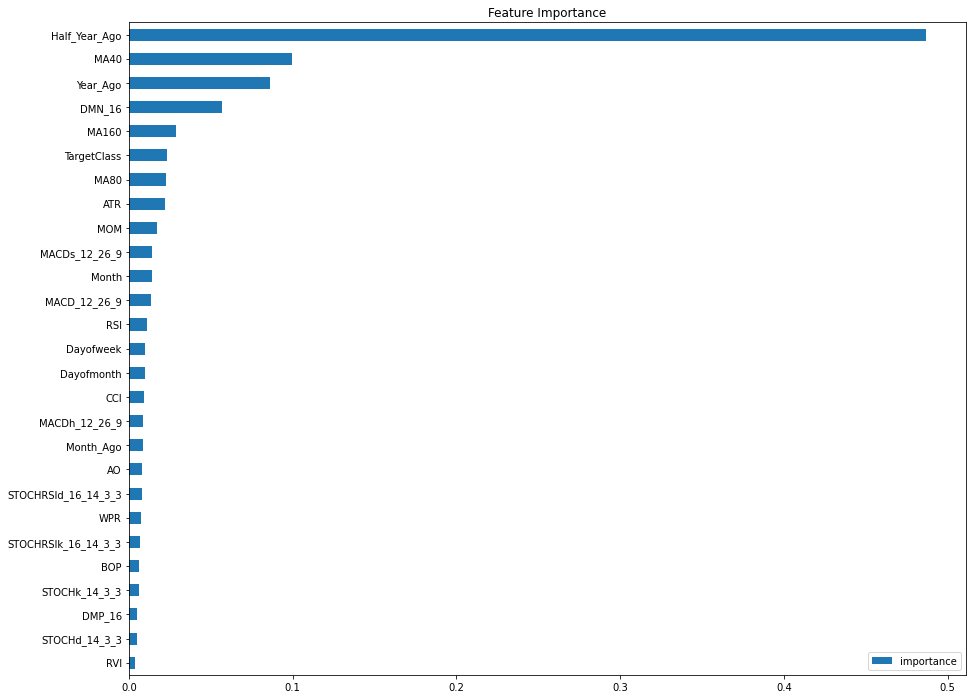

In [22]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', figsize=(15, 12),title='Feature Importance')
plt.show()

### Forecast on Test

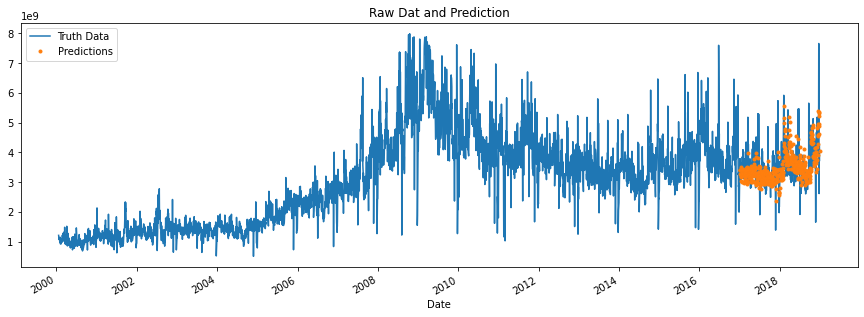

In [23]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['Volume']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

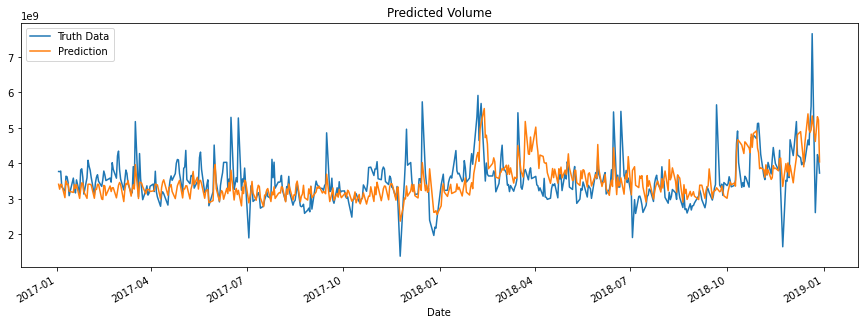

In [24]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['Volume'] \
    .plot(figsize=(15, 5), title='Predicted Volume')
df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['prediction'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.savefig('Predicted Volume.pdf')

### Score (RMSE)

In [25]:
score = np.sqrt(mean_squared_error(test['Volume'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.3f}')

RMSE Score on Test set: 537755622.842


### Calculate Error
- Look at the worst and best predicted days

In [26]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2018-09-21    2.337308e+09
2018-12-21    2.318209e+09
2017-06-23    2.039223e+09
2018-12-24    2.006524e+09
2018-07-03    1.889836e+09
2018-06-22    1.874613e+09
2017-12-15    1.712851e+09
2018-11-23    1.700172e+09
2018-02-06    1.608947e+09
2017-11-30    1.600309e+09
Name: error, dtype: float64

### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [27]:
# Create future dataframe
future = pd.date_range('2017-01-01','2018-12-31', freq='1d')
future_df = pd.DataFrame(index=future,columns=df.columns)
future_df = add_dates(future_df)
future_df = add_lags(future_df)
#df_and_future = pd.concat([df, future_df])
#df_and_future = add_dates(df_and_future)
#df_and_future = add_lags(df_and_future)
#future_w_features = df_and_future.loc[df_and_future.index > '01-01-2017'].copy()
#future_w_features.head()
future_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Average,ATR,RSI,MA40,...,Month,Year,Dayofmonth,Year_Ago,Half_Year_Ago,Month_Ago,TargetNextClose,Target,TargetClass,prediction
2018-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2018,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2018,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2018,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2018,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,2018,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
future_df['pred'] = reg.predict(future_df[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:ATR: object, RSI: object, MA40: object, MA80: object, MA160: object, CCI: object, AO: object, MOM: object, BOP: object, RVI: object, WPR: object, MACD_12_26_9: object, MACDh_12_26_9: object, MACDs_12_26_9: object, DMP_16: object, DMN_16: object, STOCHRSIk_16_14_3_3: object, STOCHRSId_16_14_3_3: object, STOCHk_14_3_3: object, STOCHd_14_3_3: object, TargetClass: object

In [ ]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '12-31-2018')]['Volume'].plot(figsize=(15, 5), title='Predicted Volume')
df.loc[(future_w_features.index > '01-01-2017') & (future_w_features.index < '12-31-2018')]['pred'].plot()
plt.legend(['Truth Data','Prediction'])
plt.savefig('Predicted Volume.pdf')

: 

## TEST 2

In [ ]:
print(df.isna().sum())
df.shape

: 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=10, test_size=183) #HALF OF THE YEAR
df = df.sort_index()

: 

In [ ]:
fig, axs = plt.subplots(10, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Volume'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Volume'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

: 

In [ ]:
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = add_dates(train)
    test = add_dates(test)

    FEATURES = ['Close', 'ATR', 'RSI', 'Dayofweek', 'Dayofmonth', 'Month']
    TARGET = 'Volume'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

: 

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

: 

### Predicting the Future
- Retraining on all data
- To Predict the future we need an emtpy dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation

In [ ]:
# Retrain on all data
df = add_dates(df)

FEATURES = ['Close', 'ATR', 'RSI', 'Dayofweek', 'Dayofmonth', 'Month']
TARGET = 'Volume'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

: 

In [ ]:
df.index.max()

: 

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = add_dates(df_and_future)
df_and_future = add_lags(df_and_future)

: 

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

: 

### Predict the future

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

: 

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

: 

### Bonus: Saving Model For later

In [ ]:
# Save model
reg.save_model('model.json')

: 

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               ms=1, lw=1,
                               title='Future Predictions')

: 

# PROPHET
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [ ]:
# Format data for prophet model using ds and y
prophet_train = pjme_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

In [ ]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

CPU times: user 3min 47s, sys: 711 ms, total: 3min 48s
Wall time: 3min 48s


In [ ]:
# Predict on test set with model
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     'PJME_MW':'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)

In [ ]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31214.768254,23771.361003,32574.576736,31214.768254,31214.768254,-2864.261748,-2864.261748,-2864.261748,-4430.327494,-4430.327494,-4430.327494,1281.386957,1281.386957,1281.386957,284.678790,284.678790,284.678790,0.0,0.0,0.0,28350.506505
1,2015-01-01 02:00:00,31214.731338,22713.811398,31450.046559,31214.731338,31214.731338,-4368.619332,-4368.619332,-4368.619332,-5927.219491,-5927.219491,-5927.219491,1272.629269,1272.629269,1272.629269,285.970889,285.970889,285.970889,0.0,0.0,0.0,26846.112005
2,2015-01-01 03:00:00,31214.694422,21335.198531,30660.419433,31214.694422,31214.694422,-5240.326860,-5240.326860,-5240.326860,-6790.297120,-6790.297120,-6790.297120,1262.665752,1262.665752,1262.665752,287.304507,287.304507,287.304507,0.0,0.0,0.0,25974.367562
3,2015-01-01 04:00:00,31214.657506,21205.757941,30219.748144,31214.657506,31214.657506,-5381.914966,-5381.914966,-5381.914966,-6922.214631,-6922.214631,-6922.214631,1251.619994,1251.619994,1251.619994,288.679670,288.679670,288.679670,0.0,0.0,0.0,25832.742540
4,2015-01-01 05:00:00,31214.620591,21739.662974,30714.323963,31214.620591,31214.620591,-4707.617961,-4707.617961,-4707.617961,-6237.342157,-6237.342157,-6237.342157,1239.627794,1239.627794,1239.627794,290.096402,290.096402,290.096402,0.0,0.0,0.0,26507.002630


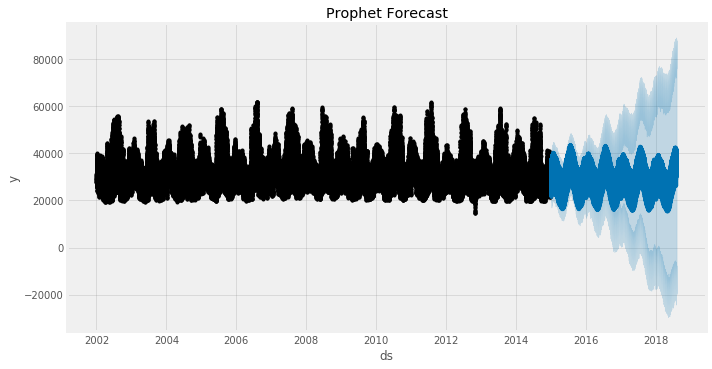

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

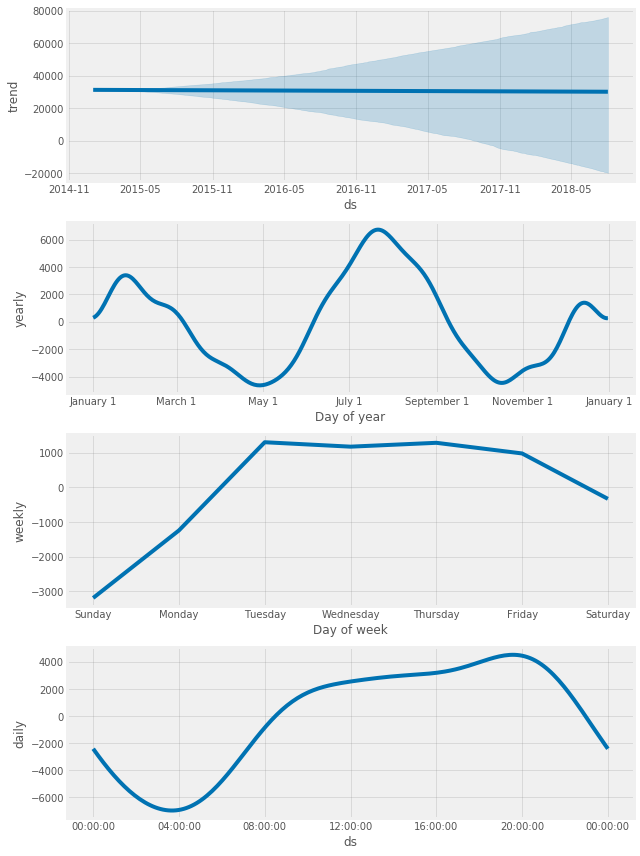

In [ ]:
fig = model.plot_components(pjme_test_fcst)
plt.show()

## Compare Forecast to Actuals

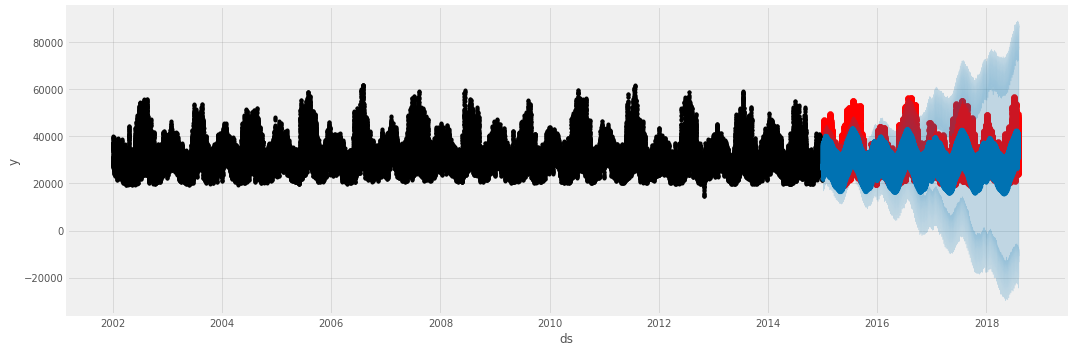

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

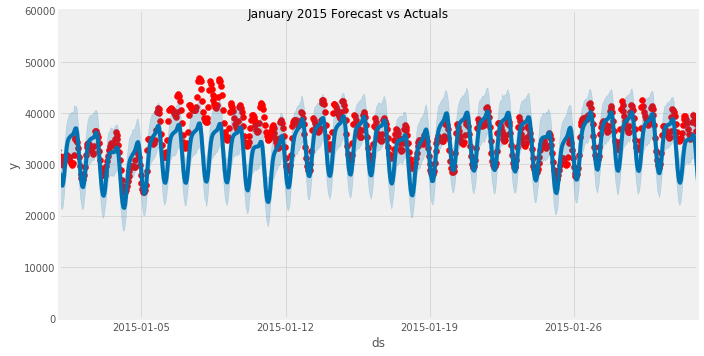

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

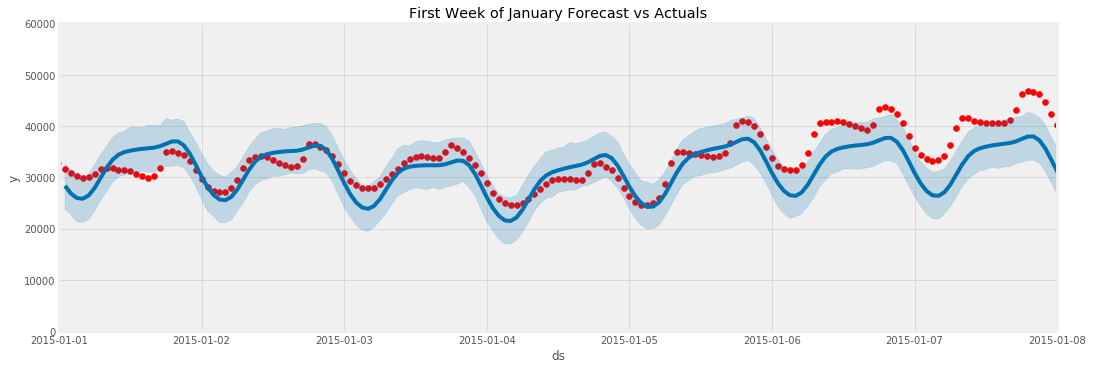

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

## Evaluate the model with Error Metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat']))

6615.260772757282

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

5181.782050398612

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst['yhat'])

16.512109913326153

## Adding Holidays

Next we will see if adding holiday indicators will help the accuracy of the model. Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

We will use the built in pandas USFederalHolidayCalendar to pull the list of holidays

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=pjme.index.min(),
                        end=pjme.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(pjme_train_prophet)

CPU times: user 2min 54s, sys: 629 ms, total: 2min 55s
Wall time: 2min 55s


In [ ]:
# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=pjme_test_prophet)

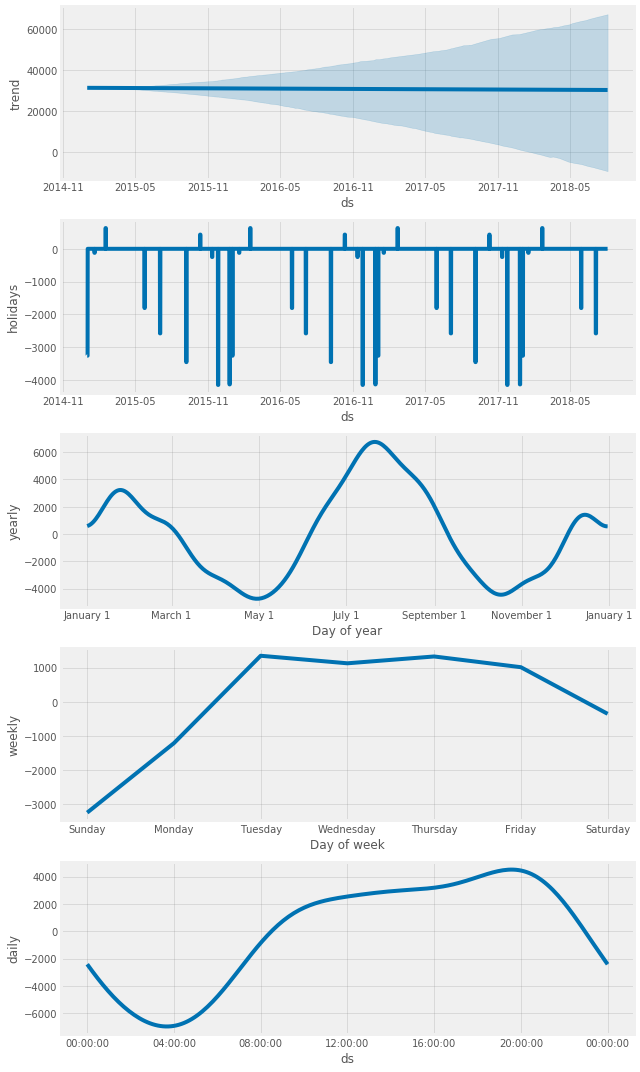

In [ ]:
fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()

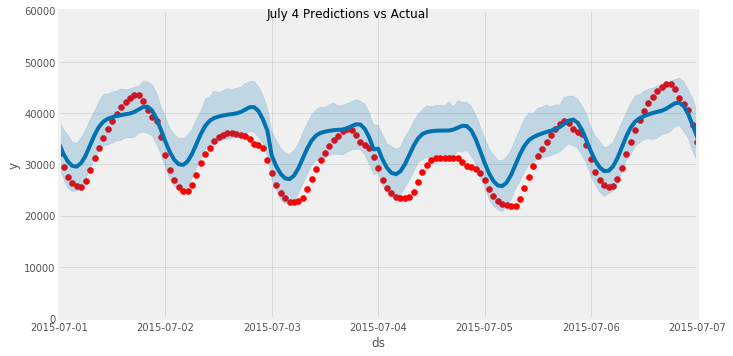

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst_with_hols, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Predictions vs Actual')

In [ ]:
np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6629.892998280289

In [ ]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

5195.461156992755

In [ ]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

16.580177835038022

## Predict into the Future

We can use the built in `make_future_dataframe` method to build our future dataframe and make predictions.

In [ ]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2015-01-01 01:00:00,25501.763125
1,2015-01-01 02:00:00,23999.616910
2,2015-01-01 03:00:00,23129.990868
3,2015-01-01 04:00:00,22990.389422
4,2015-01-01 05:00:00,23666.419956


# MIGHT DELETE LATER

## Model Building

#### Rozdělení na trénovací a testovací data

In [ ]:
x = data[['age', 'hypertension', 'heart_disease','bmi', 'gender_encoded', 'married_encoded','worktype_encoded','residence_encoded','smoker_encoded']]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
sc = StandardScaler() # standardization of test and train set
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)
print("Shape of x_train:{}".format(x_train.shape))
print("Shape of x_test:{}".format(x_test.shape))
print("Shape of y_train:{}".format(y_train.shape))
print("Shape of y_test:{}".format(y_test.shape))

: 

#### Baseline
* the most basic algorithm, where we find whether is more probable to have or not have stroke in trainign dataset
* in the testing dataset, that everyone has or does not have a troke based on the first point
* useful to check whether other algorithms are working
* in this case the moct common scenario is NO STROKE

In [ ]:
# BASELINE
y_prediction = np.zeros(len(x_test), dtype=int)
accuracy = accuracy_score(y_test, y_prediction)

: 

#### KNN
* implemented for 1-10 nearost neigbors
* runs the algorithm 9 times in total and use the k-negbors with the best result

In [ ]:
# KNN
best_accuracy = 0
best_k = 0
for k in range (1,10):
    model1 = KNeighborsClassifier(k).fit(x_train, y_train) # serach for k closest neigbors
    y_prediction1 = model1.predict(x_test)  # predict response
    accuracy1 = max(best_accuracy, accuracy_score(y_test, y_prediction1))
    if accuracy1 > best_accuracy: best_k = k
    best_accuracy = accuracy1

: 

 #### DECISION TREE

In [ ]:
# DECISION TREE
decisiontree = DecisionTreeClassifier()  # Create models
model2 = decisiontree.fit(x_train, y_train)
y_prediction2 = model2.predict(x_test)  # predict response
accuracy2 = accuracy_score(y_test, y_prediction2)

: 

#### SVM

In [ ]:
# SVM
svmmodel = svm.SVC(kernel='linear', probability=True)  # Linear Kernel
model3 = svmmodel.fit(x_train, y_train)
y_prediction3 = model3.predict(x_test)  # predict response
accuracy3 = accuracy_score(y_test, y_prediction3)

: 

#### LOGISTIC REGRESSION

In [ ]:
# LOGISTIC REGRESSION
logisticregression = LogisticRegression()
model4 = logisticregression.fit(x_train, y_train)
y_prediction4 = model4.predict(x_test)  # predict response
accuracy4 = accuracy_score(y_test, y_prediction4)

: 

## Results
* Baseline: dummiest, other algorithms should be able to be more accure
* KNN, Decision Tree, SVM, Logistic Regression

Decision trees are working the worst in this scenario, the rest is giving as the same results as baseline, which shows how hard the task is. As the majority of results are "no stroke", the algorithm learns on his own that it is the best to say that everything is not a stroke.

#### Predictions table

In [ ]:
report = pd.DataFrame()
report['Actual values'] = y_test
report['Predicted values KNN'] = y_prediction1
report['Predicted values Decision tree'] = y_prediction2
report['Predicted values SVM'] = y_prediction3
report['Predicted values Logistic Regression'] = y_prediction4
report.to_csv('predictions.csv') #save our predictions into csv file

: 

#### Accuracies

In [ ]:
print("Baseline: ",accuracy)
print("KNN: ",accuracy1, "(for "+str(best_k)+" closest neigbors)")
print("Decision Trees: ", accuracy2)
print("SVM :", accuracy3)
print("Logistic Regression: ", accuracy4)

: 

#### CONFUSION MATRIX

In [ ]:
ConfusionMatrix1 = confusion_matrix(y_test, y_prediction1)
ConfusionMatrix2 = confusion_matrix(y_test, y_prediction2)
ConfusionMatrix3 = confusion_matrix(y_test, y_prediction3)
ConfusionMatrix4 = confusion_matrix(y_test, y_prediction4)

# KNN
plt.subplots(2, 2, figsize=(10, 7))
plt.suptitle('Confusion Matrix')
plt.subplot(2, 2, 1)
ax = sns.heatmap(ConfusionMatrix1, annot=True, cmap="YlGnBu")
plt.title("KNN")
ax.set_ylabel('Actual values')

# DECISION TREE
plt.subplot(2, 2, 2)
ax = sns.heatmap(ConfusionMatrix2, annot=True, cmap="YlGnBu")
plt.title("Decision Tree")
ax.set_ylabel('Actual values')

# SVM
plt.subplot(2, 2, 3)
ax = sns.heatmap(ConfusionMatrix3, annot=True, cmap="YlGnBu")
plt.title("SVM")
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')

# LOGISTIC REGRESSION
plt.subplot(2, 2, 4)
ax = sns.heatmap(ConfusionMatrix4, annot=True, cmap="YlGnBu")
plt.title("Logistic Regression")
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values')
plt.savefig('Confusion Matrix.pdf')

: 

#### ROS CURVE

In [ ]:
    plt.subplots(2, 2, figsize=(10, 7))
    plt.suptitle('ROC Curve')
    plt.subplot(2, 2, 1)
    train_probs1 = model1.predict_proba(x_train)
    train_probs1 = train_probs1[:, 1]
    fpr1_train, tpr1_train, _ = roc_curve(y_train, train_probs1)  # pos_label=1
    test_probs1 = model1.predict_proba(x_test)
    test_probs1 = test_probs1[:, 1]
    fpr1_test, tpr1_test, _ = roc_curve(y_test, test_probs1)  # pos_label=1
    plt.plot(fpr1_train, tpr1_train, marker='.', label='train')
    plt.plot(fpr1_test, tpr1_test, marker='.', label='validation')
    plt.title('KNN')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE DECISION TREE
    plt.subplot(2, 2, 2)
    train_probs2 = model2.predict_proba(x_train)
    train_probs2 = train_probs2[:, 1]
    fpr2_train, tpr2_train, _ = roc_curve(y_train, train_probs2)  # pos_label=1
    test_probs2 = model2.predict_proba(x_test)
    test_probs2 = test_probs2[:, 1]
    fpr2_test, tpr2_test, _ = roc_curve(y_test, test_probs2)  # pos_label=1
    plt.plot(fpr2_train, tpr2_train, marker='.', label='train')
    plt.plot(fpr2_test, tpr2_test, marker='.', label='validation')
    plt.title('Decision Tree')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE MODEL SVM
    plt.subplot(2, 2, 3)
    train_probs3 = model3.predict_proba(x_train)
    train_probs3 = train_probs3[:, 1]
    fpr3_train, tpr3_train, _ = roc_curve(y_train, train_probs3)  # pos_label=1
    test_probs3 = model3.predict_proba(x_test)
    test_probs3 = test_probs3[:, 1]
    fpr3_test, tpr3_test, _ = roc_curve(y_test, test_probs3)  # pos_label=1
    plt.plot(fpr3_train, tpr3_train, marker='.', label='train')
    plt.plot(fpr3_test, tpr3_test, marker='.', label='validation')
    plt.title('SVM')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # ROC CURVE LOGISTIC REGRESSION
    plt.subplot(2, 2, 4)
    train_probs4 = model4.predict_proba(x_train)
    train_probs4 = train_probs4[:, 1]
    fpr4_train, tpr4_train, _ = roc_curve(y_train, train_probs4)  # pos_label=1
    test_probs4 = model4.predict_proba(x_test)
    test_probs4 = test_probs4[:, 1]
    fpr4_test, tpr4_test, _ = roc_curve(y_test, test_probs4)  # pos_label=1
    plt.plot(fpr4_train, tpr4_train, marker='.', label='train')
    plt.plot(fpr4_test, tpr4_test, marker='.', label='validation')
    plt.title('Logistic Regression')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.savefig('ROC Curve.pdf')

: 